In [149]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors


In [150]:
def generate_patches(img, window_size, scale):
    window = window_size * scale
    patches = []
    downsampled_patches = []
    for i in range(0, img.shape[0] - window):
        for j in range(0, img.shape[1] - window):
            patch = img[i:i + window, j:j + window]
            downsampled_patch = cv2.resize(patch, (0, 0), fx=1/scale, fy=1/scale, interpolation=cv2.INTER_CUBIC)
            patches.append(patch.flatten())
            downsampled_patches.append(downsampled_patch.flatten())
    return np.array(patches, dtype=np.float32), np.array(downsampled_patches, dtype=np.float32)

scale = 4
window_size = 5

high_res_img = cv2.imread("imm.jpeg")
# high_res_img = cv2.imread("leaves.jpg")
low_res_img = cv2.resize(high_res_img, (0, 0), fx=0.1, fy=0.1, interpolation=cv2.INTER_CUBIC)
y_channel, i_channel, q_channel = cv2.split(cv2.cvtColor(low_res_img, cv2.COLOR_BGR2YCrCb))
img = y_channel

patches_at_scale, downsampled_at_scale_patches = generate_patches(img, window_size, scale)
patches_at_half_scale, downsampled_at_half_scale_patches = generate_patches(img, window_size, scale // 2)


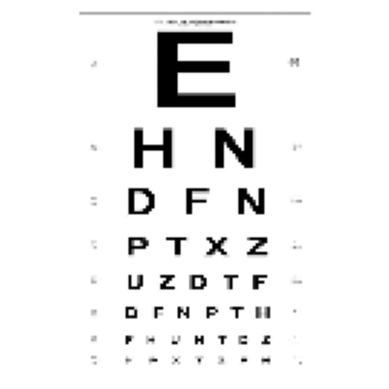

In [151]:
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


In [152]:
k_neighbors = 1
nn_model_at_scale = NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto')
nn_model_at_scale.fit(downsampled_at_scale_patches)

nn_model_at_half_scale = NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto')
nn_model_at_half_scale.fit(downsampled_at_half_scale_patches)

NearestNeighbors(n_neighbors=1)

In [153]:
# def get_SR_patch(matching_patches:
#   # return np.mean(matching_patches, axis=1)

def get_SR_patch(distances, indices, patch):
    return None
    if (min(distances) > 10):
        return None
    return patches_at_scale[indices][0].reshape(window_size*scale, window_size*scale)


def get_SR_patch_at_half_scale(distances, indices, patch):
    if (min(distances) > 10):
        return None
    half_scale_patch = patches_at_half_scale[indices][0].reshape(window_size*scale//2, window_size*scale//2)
    return cv2.resize(half_scale_patch, (0,0), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)



In [154]:
stride = 2
# Iterate through all patches
img = cv2.copyMakeBorder(img, window_size, window_size, window_size, window_size, cv2.BORDER_CONSTANT, value=0)

# Initialize a list for each pixel to store values and distances from different patches
SR_image_accumulator = [[[] for _ in range(img.shape[1]*scale)] for _ in range(img.shape[0]*scale)]
upscaled_low_res_img = cv2.resize(img, (img.shape[1]*scale, img.shape[0]*scale), interpolation=cv2.INTER_CUBIC)

def process_patch(scale, window_size, nn_model, scale_amount):
    num = 0
    for i in range(0, img.shape[0]-window_size, stride):
        for j in range(0, img.shape[1]-window_size, stride):
            patch = img[i:i+window_size, j:j+window_size].astype(np.float32).reshape(1, -1)
            distances, indices = nn_model.kneighbors(patch)
            selected_patch = None
            if scale_amount == 'half':
                selected_patch = get_SR_patch_at_half_scale(distances, indices, patch)
            else:
                selected_patch = get_SR_patch(distances, indices, patch)

            if selected_patch is None:
                continue

            num += 1
            min_distance = np.min(distances)

            # Append the values of the patch and the distance to the corresponding pixels
            for di in range(window_size*scale):
                for dj in range(window_size*scale):
                    SR_image_accumulator[i*scale+di][j*scale+dj].append((selected_patch[di, dj], min_distance))

    return num

# Process for x4 scale
num_x4 = process_patch(scale, window_size, nn_model_at_scale, 'full')
print('Proportion of patches with match for x4 scale:', num_x4 / ((img.shape[0]-window_size)//2 * (img.shape[1]-window_size)//2))

# Process for x2 scale
num_x2 = process_patch(scale, window_size, nn_model_at_half_scale, 'half')
print('Proportion of patches with match for x2 scale:', num_x2 / ((img.shape[0]-window_size)//2 * (img.shape[1]-window_size)//2))

# Fill empty pixels with corresponding pixels from the upscaled low-res image
for i in range(len(SR_image_accumulator)):
    for j in range(len(SR_image_accumulator[0])):
        if not SR_image_accumulator[i][j]:
            SR_image_accumulator[i][j].append((upscaled_low_res_img[i][j], float('inf')))

# Select the pixel value with the lowest distance for each pixel
SR_image = np.zeros((img.shape[0]*scale, img.shape[1]*scale), dtype=np.float32)
for i in range(len(SR_image_accumulator)):
    for j in range(len(SR_image_accumulator[0])):
        if SR_image_accumulator[i][j]:
            # Sort the tuples based on the second element
            sorted_values = sorted(SR_image_accumulator[i][j], key=lambda x: x[1])

            # Calculate the index to slice the lowest 20%
            slice_index = max(1, int(len(sorted_values) * 0.2))

            # Select the lowest 20% of values and calculate the average of their first elements
            avg_value = sum(value[0] for value in sorted_values[:slice_index]) / slice_index

            SR_image[i][j] = avg_value



Proportion of patches with match for x4 scale: 0.0
Proportion of patches with match for x2 scale: 0.7181590339485077


In [155]:
img = img[window_size:-window_size, window_size:-window_size]
SR_image = SR_image[window_size*scale:-window_size*scale, window_size*scale:-window_size*scale]

In [156]:
# reshape color channels to be the same size as the SR image
i_channel_resized = cv2.resize(i_channel, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
q_channel_resized = cv2.resize(q_channel, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
stacked_channels = np.stack([SR_image, i_channel_resized, q_channel_resized], axis=2)

if stacked_channels.dtype != np.uint8:
    stacked_channels = stacked_channels.astype(np.uint8)

colored_SR_image = cv2.cvtColor(stacked_channels, cv2.COLOR_YCrCb2BGR)

In [157]:
low_res_img = cv2.resize(low_res_img, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)


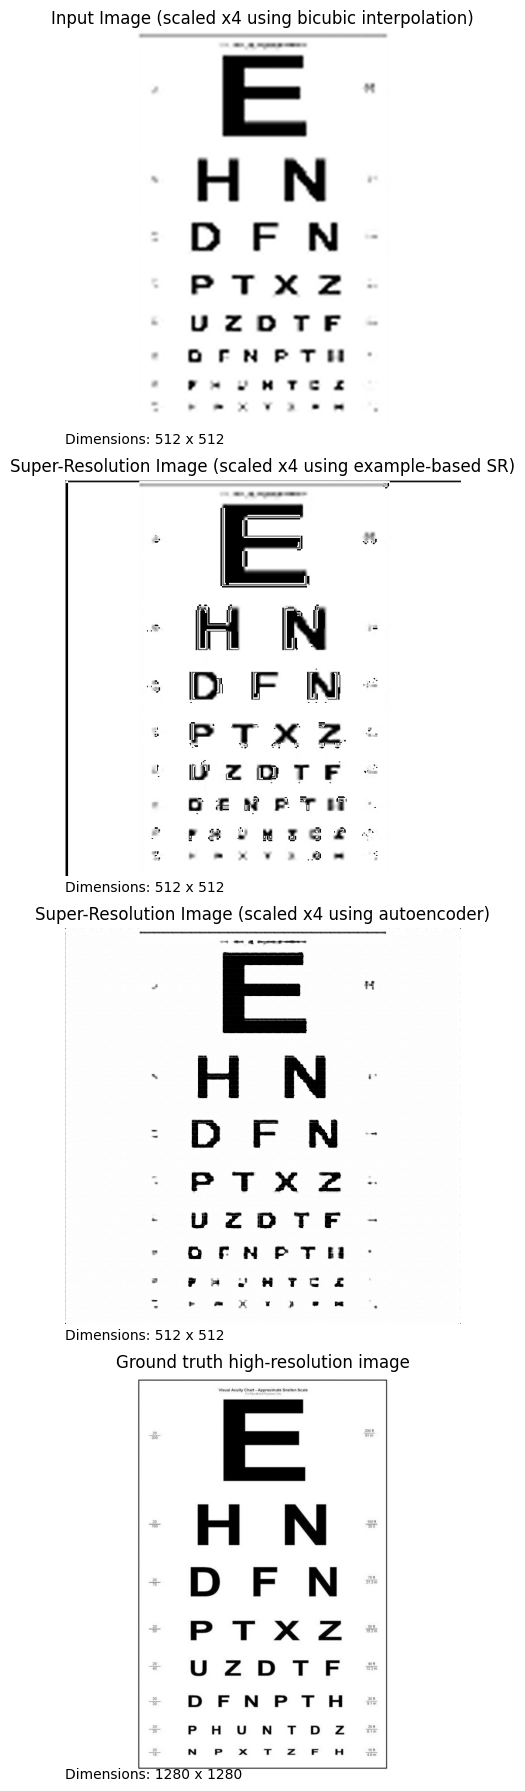

In [158]:
fig, axes = plt.subplots(4, 1, figsize=(6, 18))

# Display low-resolution image
axes[0].imshow(cv2.cvtColor(low_res_img, cv2.COLOR_BGR2RGB))
axes[0].set_title(f'Input Image (scaled x{scale} using bicubic interpolation)')
axes[0].axis('off')
axes[0].text(0, low_res_img.shape[0] + 20, f"Dimensions: {low_res_img.shape[0]} x {low_res_img.shape[1]}", ha='left')

# Display super-resolution image in grayscale
axes[1].imshow(cv2.cvtColor(colored_SR_image, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Super-Resolution Image (scaled x{scale} using example-based SR)')
axes[1].axis('off')
axes[1].text(0, colored_SR_image.shape[0] + 20, f"Dimensions: {colored_SR_image.shape[0]} x {colored_SR_image.shape[1]}", ha='left')

# Display super-resolution image using autoencoder
sr_image = cv2.imread("sr_image_eye.jpg")
axes[2].imshow(cv2.cvtColor(sr_image, cv2.COLOR_BGR2RGB))
axes[2].set_title(f'Super-Resolution Image (scaled x{scale} using autoencoder)')
axes[2].axis('off')
axes[2].text(0, sr_image.shape[0] + 20, f"Dimensions: {sr_image.shape[0]} x {sr_image.shape[1]}", ha='left')

# Display high-resolution image in color
axes[3].imshow(cv2.cvtColor(high_res_img, cv2.COLOR_BGR2RGB))
axes[3].set_title('Ground truth high-resolution image')
axes[3].axis('off')
axes[3].text(0, high_res_img.shape[0] + 20, f"Dimensions: {high_res_img.shape[0]} x {high_res_img.shape[1]}", ha='left')

plt.tight_layout()
plt.show()